# 0. Workflow

Train a deep convolutional neural network for (supervised) classification of melanoma positive and negative images. Compare the performance of the model trained from scratch to that which has been pre-trained on another dataset.

**Workflow**

- Use the labeled Dataset class from milestone 2 and separate the images in the labeled folder into train and validation sets.

- Construct and train your supervised melanoma classifier.

- Transfer learning is a popular machine learning (ML) approach when training data is scarce. Either choose a pre-trained model out of the ones available in the torchvision.models package, or train on a (large) dataset of choice, and fine-tune it on melanoma data. How does its performance compare to the fully supervised classifier that you trained from scratch in previous step?

- When transfer learning does not prove to be sufficient, another option that we have is to take advantage of the unlabeled data by employing a semi-supervised ML strategy. Semi-supervised learning is a rapidly developing field, so the best place to look for the state-of-the-art methods is the famous arXiv.org, an open-access archive containing thousands of articles across numerous scientific disciplines, including computer science. Learning to work with the arXiv is an important skill for ML engineers involved in solving non trivial problems. Spend some time to find at least 2-3 different approaches that have shown to be successful in semi-supervised ML for computer vision applications, and list them along with the arXiv references that you found.



# First attempt to train classifier - overfitting

## 1. Training from scratch


Important imports.

In [63]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import skimage
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms, utils, models
from PIL import Image
import timeit                        # to evaluate elements of code
import time
import cv2
import tensorflow.compat.v1 as tf    # to avoid attributeError:
import random
import tensorflow_addons as tfa
import math
import sklearn.model_selection
from numba import cuda
import torchvision
from google.colab import drive       # to add data path
import copy

## 1.1 Data augmentation

Using concepts from previous milestone.

In [64]:
class Rot_90_torch(object):
    """Rotate the object anticlockwise 
    by random number times 90 degree"""
    def __init__(self):
        r = np.linspace(-2, 2, 5)    # all possible rotations by 90 degree
        k = random.choice(r)
        self.no = int(k)
    def __call__(self, img):
        tr = transforms.RandomRotation((self.no*90, self.no*90))
        return tr(img)

In [65]:
class Rot(object):
    """Flip the object with respect to first dimension."""
    def _largest_rotated_rect(self, w, h):
        """
        Given a rectangle of size w x h that has been rotated by 'angle' (in
        radians), computes the width and height of the largest possible
        axis-aligned rectangle within the rotated rectangle.
        Original JS code by 'Andri' and Magnus Hoff from Stack Overflow
        Converted to Python by Aaron Snoswell
        Source: http://stackoverflow.com/questions/16702966/rotate-image-and-crop-out-black-borders
        """
        angle = math.radians(15)
        quadrant = int(math.floor(angle / (math.pi / 2))) & 3
        sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle
        alpha = (sign_alpha % math.pi + math.pi) % math.pi

        bb_w = w * math.cos(alpha) + h * math.sin(alpha)
        bb_h = w * math.sin(alpha) + h * math.cos(alpha)

        gamma = math.atan2(bb_w, bb_w) if (w < h) else math.atan2(bb_w, bb_w)

        delta = math.pi - alpha - gamma

        length = h if (w < h) else w

        d = length * math.cos(alpha)
        a = d * math.sin(alpha) / math.sin(delta)

        y = a * math.cos(gamma)
        x = y * math.tan(gamma)

        return (
            bb_w - 2 * x,
            bb_h - 2 * y
        )
    def __call__(self, img):
        tr_0 = transforms.Resize(32)
        tr_1 = transforms.RandomRotation((-15, 15), resample = Image.NEAREST)
        img = tr_1(img)
        lrr_width, lrr_height = self._largest_rotated_rect(32, 32)
        tr_2 = transforms.CenterCrop((lrr_height,lrr_width))  
        img = tr_0(tr_2(img))
        return img

Augmentations were composed from the torchvision transforms and simple classes from previous milestone. Alternative, simpler augmentation can help with comparison.

In [66]:
augmentation = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(), 
                                   transforms.Resize(36), transforms.RandomCrop(32), Rot_90_torch(), Rot(), transforms.ToTensor()])

# or alternative, simpler augmentation to comparison:
# rotation = transforms.RandomChoice([transforms.RandomRotation([-3,3]),
#                                     transforms.RandomRotation([87,93]), 
#                                     transforms.RandomRotation([177,183]),
#                                     transforms.RandomRotation([267, 273])])
# augmentation = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(), rotation, transforms.ToTensor()])

## 1.2 Dataset classes

Classes from previous milestone.

In [67]:
class MelanomaDataset_unlab(Dataset):
    """melanoma detection dataset for unlabeled data set"""

    def __init__(self, images_dir, transform = None, through = 'pil'):
        """
        Args:
            images_dir (string): directory with all the images.
            transform (callable, optional): optional transform to be applied
                on a sample.
        """
        self.images_dir = images_dir
        self.transform = transform
        self.through = through

    def __len__(self):
        return len([i for i in os.listdir(self.images_dir) if '.jpg' in i])

    def __getitem__(self, idx):
        
        img_name = os.path.join(self.images_dir,
                                '{}.jpg'.format(str(idx)))
        through = self.through
        if through == 'skimage':
            image = io.imread(img_name)
        elif through == 'plt':
            image = plt.imread(img_name, format = 'jpg')
        elif through == 'pil':
            image = Image.open(img_name)
        elif through == 'cv':
            image = cv2.imread(img_name)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            raise NameError("name '{}' is not defined.".format(thro))
        sample = image
        if self.transform != None:
            sample = self.transform(sample)
        return sample

class MelanomaDataset_lab(Dataset):
    """melanoma detection dataset for labelled data"""

    def __init__(self, images_dir, transform = None, through = 'pil'):
        """
        Args:
            images_dir (string): directory with all the images.
            transform (callable, optional): optional transform to be applied
                on a sample.
        """
        self.images_dir = images_dir
        self.transform = transform
        self.through = through

    def __len__(self):
        return len([i for i in os.listdir(self.images_dir) if '.jpg' in i])

    def __getitem__(self, idx, through = 'cv'):
        through = self.through
        try:
            img_name = os.path.join(self.images_dir,
                                    '{}_1.jpg'.format(str(idx)));\
            label = 1
            if through == 'skimage':
                image = io.imread(img_name)
            elif through == 'plt':
                image = plt.imread(img_name, format = 'jpg')
            elif through == 'pil':
                image = Image.open(img_name)
            elif through == 'cv':
                image = cv2.imread(img_name)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            else:
                raise NameError("name '{}' is not defined.".format(thro))
        except:
            img_name = os.path.join(self.images_dir,
                                    '{}_0.jpg'.format(str(idx)));
            label = 0
            if through == 'skimage':
                image = io.imread(img_name)
            elif through == 'plt':
                image = plt.imread(img_name, format = 'jpg')
            elif through == 'pil':
                image = Image.open(img_name)
            elif through == 'cv':
                image = cv2.imread(img_name)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            else:
                raise NameError("name '{}' is not defined.".format(thro))
        sample = image
        if self.transform != None:
            sample = self.transform(sample)
        return sample, label

## 1.3 Mounting google drive

In [68]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
DATA_PATH = "/content/drive/My Drive/Melanoma_dataset/"

In [70]:
!ls "$DATA_PATH"

labeled			     second_model_batch_size_16.pt  unlabeled
second_attempt_resnet_18.pt  test


## 1.4 Declaring data sets

In [99]:
unlabeled_set = MelanomaDataset_unlab("/content/drive/My Drive/Melanoma_dataset/unlabeled", transform = augmentation)
labeled_set = MelanomaDataset_lab("/content/drive/My Drive/Melanoma_dataset/labeled/", transform = augmentation)
test_set = MelanomaDataset_lab("/content/drive/My Drive/Melanoma_dataset/test", transform = transforms.Compose([transforms.ToTensor()]))

print('Number of TEST images: ', len(test_set))
print('Number of LABELED images: ', len(labeled_set))
print('Number of UNLABELED images: ', len(unlabeled_set))

Number of TEST images:  600
Number of LABELED images:  200
Number of UNLABELED images:  7018


In [100]:
#unlabeled_set_1 = MelanomaDataset_unlab('MelanomaDetection/MelanomaDetection/unlabeled', transform = transforms.ToTensor())
#labeled_set_1 = MelanomaDataset_lab('MelanomaDetection/MelanomaDetection/labeled', transform = transforms.ToTensor())

In [101]:
X_train, X_eval = torch.utils.data.random_split(labeled_set, [170, 30])

In [102]:
print('Training set:', len(X_train))

Training set: 170


In [103]:
print('Valuation set:', len(X_eval))

Valuation set: 30


Visualisation of sample batch from DataLoader above.

Batch labels:  tensor([0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1])


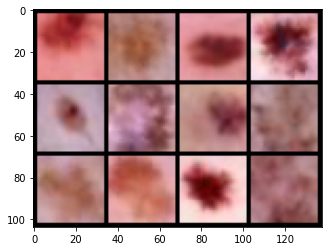

Batch labels:  tensor([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1])


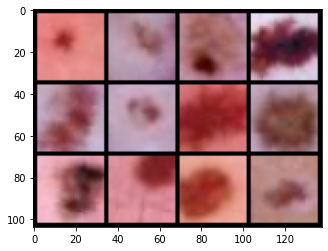

In [104]:
labeled_loader = DataLoader(labeled_set, batch_size=12, shuffle=True, num_workers=16)

for batch_idx, batch in enumerate(labeled_loader):
    
    '''
    Here the batch contains both images and labels.
    '''
    
    # Stop after two batches
    if batch_idx == 2:
        break

    print("Batch labels: ", batch[1].data)
    
    # torchvision provides functions that facilitate displaying batches
    # of images that come in the form of PyTorch tensors:
    image_grid = torchvision.utils.make_grid(batch[0], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0))
    plt.pause(0.05)

## 1.5 Training the network from scratch on GPU without normalisation

In [105]:
import torch.nn.functional as F
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size = 3, padding = 1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
 
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        #out = F.max_pool2d(torch.tanh(self.conv3(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

# Code below is JUST guidance/notes on adding layers, adding new layers did not enhanced learning in this case
# import torch.nn.functional as F
# import torch.nn as nn

# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 128, kernel_size = 3, padding = 1)
#         self.conv2 = nn.Conv2d(128, 64, kernel_size = 3, padding = 1)
#         self.conv4 = nn.Conv2d(64, 32, kernel_size = 3, padding = 1)
#         self.conv5 = nn.Conv2d(32, 16, kernel_size = 3, padding = 1)
#         self.conv6 = nn.Conv2d(16, 8, kernel_size = 3, padding = 1)
#         self.fc1 = nn.Linear(8 * 1 * 1, 32)
#         self.fc2 = nn.Linear(32, 2)
 
#     def forward(self, x):
#         out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
#         # print(out.shape)
#         out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
#         # print(out.shape)
#         out = F.max_pool2d(torch.tanh(self.conv4(out)), 2)
#         # print(out.shape)
#         out = F.max_pool2d(torch.tanh(self.conv5(out)), 2)
#         # print(out.shape)
#         out = F.max_pool2d(torch.tanh(self.conv6(out)), 2)
#         # print(out.shape)
#         out = out.view(-1, 8 * 1 * 1)
#         # print(out.shape)
#         out = torch.tanh(self.fc1(out))
#         # print(out.shape)
#         out = self.fc2(out)
#         return out

In [106]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
 
            outputs = model(imgs)
 
            loss = loss_fn(outputs, labels)
 
            optimizer.zero_grad()
 
            loss.backward()
 
            optimizer.step()
 
            loss_train += loss.item()
 
        if epoch == 1 or epoch % 100 == 0:
          print('{} Epoch {}, Training loss {}'.format(
              datetime.datetime.now(), epoch,
              loss_train / len(train_loader)))

In [107]:
device = (torch.device('cuda') if torch.cuda.is_available()
         else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [108]:
import datetime


def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device = device)
            labels = labels.to(device = device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
 
            loss_train += loss.item()
 
        if epoch == 1 or epoch % 100 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [109]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [110]:
train_loader = torch.utils.data.DataLoader(X_train, batch_size = len(X_train),
                                           shuffle = False)
model = Net().to(device=device)
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)
loss_fn = nn.CrossEntropyLoss()
 
training_loop(
    n_epochs = 1000,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2020-10-08 21:52:17.743273 Epoch 1, Training loss 0.6956878900527954
2020-10-08 21:52:44.976833 Epoch 100, Training loss 0.6960552334785461
2020-10-08 21:53:09.471030 Epoch 200, Training loss 0.6940908432006836
2020-10-08 21:53:33.913853 Epoch 300, Training loss 0.6943427920341492
2020-10-08 21:53:58.700831 Epoch 400, Training loss 0.6943771839141846
2020-10-08 21:54:23.497651 Epoch 500, Training loss 0.69346684217453
2020-10-08 21:54:48.211777 Epoch 600, Training loss 0.6941206455230713
2020-10-08 21:55:13.425816 Epoch 700, Training loss 0.6929241418838501
2020-10-08 21:55:38.160399 Epoch 800, Training loss 0.693187952041626
2020-10-08 21:56:02.907222 Epoch 900, Training loss 0.6923287510871887
2020-10-08 21:56:27.514252 Epoch 1000, Training loss 0.6913384199142456


In [111]:
torch.save(model.state_dict(), DATA_PATH + 'second_model.pt')
model = Net().to(device=device)
model.load_state_dict(torch.load(DATA_PATH + 'second_model.pt'))

<All keys matched successfully>

In [112]:
train_loader = torch.utils.data.DataLoader(X_train, batch_size = 64,
                                           shuffle = True)
val_loader = torch.utils.data.DataLoader(X_eval, batch_size = 64,
                                         shuffle = True)
 
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
 
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
 
        print("Accuracy {}: {:.2f}".format(name , correct / total))
 
validate(model, train_loader, val_loader)

Accuracy train: 0.50
Accuracy val: 0.53


In [113]:
val_loader = torch.utils.data.DataLoader(test_set, batch_size = 64,
                                         shuffle = True)
 
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("test", val_loader)]:
        correct = 0
        total = 0
 
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
 
        print("Accuracy {}: {:.2f}".format(name , correct / total))
 
validate(model, train_loader, val_loader)

Accuracy train: 0.50
Accuracy test: 0.50


Here it is obvious that model above is no better than baseline of random choice.

## 1.6 Finding the norm of images to use normalisation

In [20]:
norm = DataLoader(labeled_set, batch_size = 12, shuffle = False, num_workers = 16)

nimages = 0
mean = 0.
std = 0.
for batch, _ in norm:
    # Rearrange batch to be the shape of [B, C, W * H]
    batch = batch.view(batch.size(0), batch.size(1), -1)
    # Update total number of images
    nimages += batch.size(0)
    # Compute mean and std here
    mean += batch.mean(2).sum(0) 
    std += batch.std(2).sum(0)

# Final step
mean /= nimages
std /= nimages

print('Mean of images in dataset: ', mean)
print('Standard deviation of images in dataset: ', std)

normalization = transforms.Normalize(mean, std)

Mean of images in dataset:  tensor([0.7121, 0.4809, 0.4936])
Standard deviation of images in dataset:  tensor([0.1017, 0.1319, 0.1446])


Composed augmentations with normalisation:

In [21]:
augmentation_1 = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(), transforms.Resize(36), transforms.RandomCrop(32), Rot_90_torch(), Rot(), transforms.ToTensor(),normalization])

In [89]:
unlabeled_set_n = MelanomaDataset_unlab("/content/drive/My Drive/Melanoma_dataset/unlabeled", transform = augmentation_1)
labeled_set_n = MelanomaDataset_lab("/content/drive/My Drive/Melanoma_dataset/labeled/", transform = augmentation_1)
test_set_n = MelanomaDataset_lab("/content/drive/My Drive/Melanoma_dataset/test", transform = transforms.Compose([transforms.ToTensor(), normalization]))
X_train_n, X_eval_n = torch.utils.data.random_split(labeled_set_n, [170, 30])

### 1.6.1 Training the normalised images network from scratch on GPU

In [90]:
import torch.nn.functional as F
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size = 3, padding = 1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
 
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        #out = F.max_pool2d(torch.tanh(self.conv3(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

# Code below is JUST guidance/notes on adding layers, adding new layers did not enhanced learning in this case
# import torch.nn.functional as F
# import torch.nn as nn

# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 128, kernel_size = 3, padding = 1)
#         self.conv2 = nn.Conv2d(128, 64, kernel_size = 3, padding = 1)
#         self.conv4 = nn.Conv2d(64, 32, kernel_size = 3, padding = 1)
#         self.conv5 = nn.Conv2d(32, 16, kernel_size = 3, padding = 1)
#         self.conv6 = nn.Conv2d(16, 8, kernel_size = 3, padding = 1)
#         self.fc1 = nn.Linear(8 * 1 * 1, 32)
#         self.fc2 = nn.Linear(32, 2)
 
#     def forward(self, x):
#         out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
#         # print(out.shape)
#         out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
#         # print(out.shape)
#         out = F.max_pool2d(torch.tanh(self.conv4(out)), 2)
#         # print(out.shape)
#         out = F.max_pool2d(torch.tanh(self.conv5(out)), 2)
#         # print(out.shape)
#         out = F.max_pool2d(torch.tanh(self.conv6(out)), 2)
#         # print(out.shape)
#         out = out.view(-1, 8 * 1 * 1)
#         # print(out.shape)
#         out = torch.tanh(self.fc1(out))
#         # print(out.shape)
#         out = self.fc2(out)
#         return out

In [91]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
 
            outputs = model(imgs)
 
            loss = loss_fn(outputs, labels)
 
            optimizer.zero_grad()
 
            loss.backward()
 
            optimizer.step()
 
            loss_train += loss.item()
 
        if epoch == 1 or epoch % 100 == 0:
          print('{} Epoch {}, Training loss {}'.format(
              datetime.datetime.now(), epoch,
              loss_train / len(train_loader)))

In [92]:
device = (torch.device('cuda') if torch.cuda.is_available()
         else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [93]:
import datetime


def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device = device)
            labels = labels.to(device = device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
 
            loss_train += loss.item()
 
        if epoch == 1 or epoch % 100 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [94]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [95]:
train_loader = torch.utils.data.DataLoader(X_train_n, batch_size = len(X_train_n),
                                           shuffle = False)
model = Net().to(device=device)
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)
loss_fn = nn.CrossEntropyLoss()
 
training_loop(
    n_epochs = 1000,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2020-10-08 21:45:05.803954 Epoch 1, Training loss 0.6805130243301392
2020-10-08 21:45:33.741738 Epoch 100, Training loss 0.6251981854438782
2020-10-08 21:46:01.830152 Epoch 200, Training loss 0.5838743448257446
2020-10-08 21:46:29.274803 Epoch 300, Training loss 0.5604255199432373
2020-10-08 21:46:56.388936 Epoch 400, Training loss 0.5477787852287292
2020-10-08 21:47:25.562454 Epoch 500, Training loss 0.543626606464386
2020-10-08 21:47:52.308237 Epoch 600, Training loss 0.5366011261940002
2020-10-08 21:48:18.945258 Epoch 700, Training loss 0.5323134660720825
2020-10-08 21:48:46.029327 Epoch 800, Training loss 0.5314285159111023
2020-10-08 21:49:12.955072 Epoch 900, Training loss 0.528351902961731
2020-10-08 21:49:39.981816 Epoch 1000, Training loss 0.5239734649658203


Saving and loading back the trained model.

In [96]:
torch.save(model.state_dict(), DATA_PATH + 'second_model_batch_size_16_normalised_samples.pt')
model = Net().to(device=device)
model.load_state_dict(torch.load(DATA_PATH + 'second_model_batch_size_16_normalised_samples.pt'))

<All keys matched successfully>

In [97]:
train_loader = torch.utils.data.DataLoader(X_train_n, batch_size = 64,
                                           shuffle = True)
val_loader = torch.utils.data.DataLoader(X_eval_n, batch_size = 64,
                                         shuffle = True)
 
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
 
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
 
        print("Accuracy {}: {:.2f}".format(name , correct / total))
 
validate(model, train_loader, val_loader)

Accuracy train: 0.78
Accuracy val: 0.70


In [98]:
val_loader = torch.utils.data.DataLoader(test_set_n, batch_size = 64,
                                         shuffle = True)
 
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("test", val_loader)]:
        correct = 0
        total = 0
 
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
 
        print("Accuracy {}: {:.2f}".format(name , correct / total))
 
validate(model, train_loader, val_loader)

Accuracy train: 0.76
Accuracy test: 0.72


# 2. Transfer learning - Finetuning Torchvision Models using VGG11

Using VGG-11

In [132]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


In [133]:
# top level data directory
data_dir = DATA_PATH

model_name = "vgg"

# number of classes in the dataset
num_classes = 2

batch_size = 64

num_epochs = 100

# Flag for feature extracting. When False, it finetune the whole model,
# when True it only updates the reshaped layer params
feature_extract = False

In [134]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs = 25, is_inception = False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [135]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [136]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg11', pretrained = False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [137]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [138]:
model.classifier[6] = nn.Linear(4096, 2)

In [139]:
model_ft = models.vgg11_bn(pretrained = True)
set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
input_size = 32

In [140]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

In [141]:
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr = 0.001, momentum = 0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.1.weight
	 features.1.bias
	 features.4.weight
	 features.4.bias
	 features.5.weight
	 features.5.bias
	 features.8.weight
	 features.8.bias
	 features.9.weight
	 features.9.bias
	 features.11.weight
	 features.11.bias
	 features.12.weight
	 features.12.bias
	 features.15.weight
	 features.15.bias
	 features.16.weight
	 features.16.bias
	 features.18.weight
	 features.18.bias
	 features.19.weight
	 features.19.bias
	 features.22.weight
	 features.22.bias
	 features.23.weight
	 features.23.bias
	 features.25.weight
	 features.25.bias
	 features.26.weight
	 features.26.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


In [142]:
data_transforms = {
    'train': augmentation_1,
    'val': transforms.Compose([
        transforms.ToTensor(),normalization]),
}

# Create training and validation dataloaders
print(type(X_eval))
print(type(X_train))
X_train_1 = DataLoader(X_train, batch_size = batch_size, shuffle = True, num_workers = 8)
X_eval_1 = DataLoader(X_eval, batch_size = batch_size, shuffle = True, num_workers = 8) 
print(type(X_eval_1))
print(type(X_train_1))
dataloaders_dict = {'train': X_train_1, 'val': X_eval_1}

<class 'torch.utils.data.dataset.Subset'>
<class 'torch.utils.data.dataset.Subset'>
<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [143]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, 
                             optimizer_ft, num_epochs = num_epochs, 
                             is_inception = False)

Epoch 0/99
----------
train Loss: 0.7583 Acc: 0.4765
val Loss: 0.6558 Acc: 0.6667

Epoch 1/99
----------
train Loss: 0.6853 Acc: 0.5353
val Loss: 0.6746 Acc: 0.5667

Epoch 2/99
----------
train Loss: 0.6597 Acc: 0.5882
val Loss: 0.5856 Acc: 0.6667

Epoch 3/99
----------
train Loss: 0.6249 Acc: 0.6412
val Loss: 0.5558 Acc: 0.7000

Epoch 4/99
----------
train Loss: 0.5704 Acc: 0.6824
val Loss: 0.4951 Acc: 0.8000

Epoch 5/99
----------
train Loss: 0.5498 Acc: 0.7412
val Loss: 0.4856 Acc: 0.7667

Epoch 6/99
----------
train Loss: 0.5260 Acc: 0.7765
val Loss: 0.4294 Acc: 0.7667

Epoch 7/99
----------
train Loss: 0.5056 Acc: 0.7765
val Loss: 0.4097 Acc: 0.8333

Epoch 8/99
----------
train Loss: 0.4431 Acc: 0.7941
val Loss: 0.4147 Acc: 0.8333

Epoch 9/99
----------
train Loss: 0.4120 Acc: 0.8000
val Loss: 0.4173 Acc: 0.9000

Epoch 10/99
----------
train Loss: 0.3394 Acc: 0.8412
val Loss: 0.3914 Acc: 0.8333

Epoch 11/99
----------
train Loss: 0.3957 Acc: 0.7882
val Loss: 0.3992 Acc: 0.8000

Ep

In [144]:
torch.save(model_ft.state_dict(), DATA_PATH + 'second_attempt_vgg11.pt')
model_ft = models.vgg11_bn(pretrained = True)
set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
input_size = 32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)
model_ft.load_state_dict(torch.load(DATA_PATH + 'second_attempt_vgg11.pt'))

<All keys matched successfully>

In [146]:
test_loader = torch.utils.data.DataLoader(test_set_n, batch_size = 64,
                                         shuffle = True)
 
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("test", test_loader)]:
        correct = 0
        total = 0
 
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
 
        print("Accuracy {}: {:.2f}".format(name , correct / total))
 
validate(model_ft, train_loader, test_loader)

Accuracy train: 0.99
Accuracy test: 0.75


## 2.1 Second attempt to transfer learning - Resnet18

In [58]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = models.resnet18(pretrained = False)
num_ftrs = model.fc.in_features

'''
Below I replace the original nn.Linear(model.fc.in_features, model.fc.out_features) with two layers,
combined into a single nn.Sequential module: nn.Linear(model.fc.in_features, 1) that is followed by
a Sigmoid layer.
'''
model.fc = nn.Sequential(nn.Linear(num_ftrs, 1), nn.Sigmoid())
model = model.to(device)

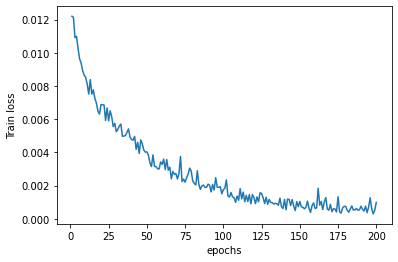

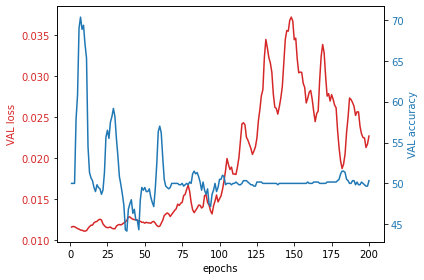

Accuracy on the test set:  70.33333333333333


In [59]:
criterion = nn.BCELoss()

optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)

def train(model, device, train_loader, optimizer):
    
    # train() is the mode that "turns on" the non-deterministic layers
    # that may be present in the model (e.g. dropout, batchnorm, etc)
    model.train()
    
    epoch_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = data.to(device), target.type(torch.FloatTensor).to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.squeeze(), target.squeeze())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    epoch_loss /= len(train_loader.dataset)
    return epoch_loss


def test(model, device, test_loader):
    
    # eval() is the mode that "turns off" the non-deterministic layers
    # that may be present in the model (e.g. dropout, batchnorm, etc)
    model.eval()
    
    test_loss = 0
    correct = 0
    
    one = torch.ones(1, 1).to(device)
    zero = torch.zeros(1, 1).to(device)
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.type(torch.FloatTensor).to(device)
            output = model(data)
            test_loss += criterion(output.squeeze(), target.squeeze()).item()  # sum up batch loss
            pred = torch.where(output.squeeze()<0.5, zero, one)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)    
    return test_loss, (100. * correct / len(test_loader.dataset))

train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 200

best_model_wts = copy.deepcopy(model.state_dict())
best_accuracy = 0.0
    
for epoch in range(1, num_epochs+1):
    train_losses.append(train(model, device, train_loader, optimizer))
    val_loss, val_accuracy = test(model, device, val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model_wts = copy.deepcopy(model.state_dict())

      
plt.plot(range(1, num_epochs+1), np.array(train_losses))
plt.ylabel('Train loss')
plt.xlabel('epochs')
plt.show()

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('VAL loss', color=color)
ax1.plot(range(1, num_epochs+1), np.array(val_losses), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('VAL accuracy', color=color)  
ax2.plot(range(1, num_epochs+1), np.array(val_accuracies), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

# load best model weights
model.load_state_dict(best_model_wts)
_, test_accuracy = test(model, device, test_loader)
print("Accuracy on the test set: ", test_accuracy)

In [61]:
torch.save(model.state_dict(), DATA_PATH + 'second_attempt_resnet_18.pt')
model = Net().to(device=device)
model.load_state_dict(torch.load(DATA_PATH + 'second_attempt_resnet_18.pt'))

<All keys matched successfully>

Both VGG11 and Resnet18 did not achieve much better results than simple convolutional network. Most of the pre-trained models provided in torchvision.models have been trained on images sized 224x224 that come from a natural domain (e.g. the ImageNet). This difference from 32x32 images of moles in data set is what is behind the small improvement in the final accuracy that was achieve compared to the model that was trained from scratch (Part A above).

# 3. Further research

The "semi supervised image classification" query returns close to 200 results. Skimming the abstracts of the pre-prints that have been posted within the last year, we can see, for instance, the following semi-supervised learning (SSL) approaches:

  - Consistency regularization: an SSL technique that involves augmenting unlabeled data and encouraging the model to be robust to the augmentations. (2003.12022)

  - Semi-supervised teacher-student knowledge distillation: the teacher model gets trained on the labeled data, then makes predictions for the unlabeled data. The student model is then trained to mimic the top-confidence predictions of the teacher. (1905.00546, 2003.08797)

  - Something graph-based that I would not know what to say about without reading the paper in depth.

  - Generative SSL: a generative model, such as a Variational Autoencoder (VAE) or a Generative Adversarial Network (GAN) that is trained on the unlabeled data, is then used to help train the supervised model together with the labeled data. (1912.09784, 2002.12164)

  etc